In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pymc3 as pm

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#Seismic displacement in three-dimensions

#Defining the main parameters of the model
rho0 = 1800 #Density of the homogeneous medium in kg/m^3, as taken from Beker's thesis paper, pg. 84
alpha = 0.31 #Parameter used in Beker's paper to determine primary wave speed pg. 84
beta = 0.25 #Parameter used in Beker's paper to determine primary wave speed pg 84.
nu = 0.25 #Poisson ratio as taken from Beker's thesis paper pg. 84

#Calculating the wave speeds using above paramters
CP = ((rho0/1000) / alpha)**(1.0 / beta) #Calculating primary wave speed using equation from Beker's paper, pg. 84
CS = np.sqrt((1-2*nu)/(2-2*nu)) * CP #Calculating secondary wave speed using equation from Beker's paper, pg. 84
Root = np.roots([1, -8, 8 * ((2 - nu)/(1 - nu)), -8 / (1 - nu)]) #Calculating the the ratio of the R wave speed to the p wave speed squared using equation found in Harm's and Beker's paper, pg. 20 in Beker's paper
for i in Root:
    if 0<i<1:
        CR = np.sqrt(CS**2 *i) #calculating R wave speed

x2_list = np.linspace(0, 500, 24) #x-values to be evaluated
y2_list = np.linspace(0, 500, 24) #y-values to be evaluated
z2_list = np.array([0]) #z-values to be evaluated
t2_list = np.linspace(2, 4, 50) #time interval to be evaluated over

#Calculating seismic displacement using equation from Harm's paper "Terrestial Gravity Fluctuations", pg. 31 
def xi_horiz(x, y, z, t, f, theta, phi): 
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (ke * np.exp(q_z_p * z) - zeta * np.exp(q_z_s * z)) * np.sin(np.dot(ke_vec, [x,y]) - omega * t + phi)

def xi_vert(x, y, z, t, f, theta, phi):
    omega = 2*np.pi*f #calculating the angular frequency
    ke = omega / CR #Calculating horizontal wave number of the Rayleigh wave
    ke_vec = [np.cos(theta) * ke, np.sin(theta) * ke] #Rayleigh wave vector in x-y plane
    ks = omega / CS #Calculatin the secondary wave number of the Rayleigh wave
    kp = omega / CP #Calculating the primary wave number of the Rayleigh wave
    q_z_s = np.sqrt(ke**2 - ks**2) #Calculating wave parameter used in Harm's model, pg. 31
    q_z_p = np.sqrt(ke**2 - kp**2) #Calculating wave parameter used in Harm's model, pg. 31
    zeta = np.sqrt(q_z_p / q_z_s) #Calculating wave parameter used in Harm's model, pg. 32
    return (q_z_p * np.exp(q_z_p * z) - zeta * ke * np.exp(q_z_s * z)) * np.cos(np.dot(ke_vec, [x,y]) - omega * t + phi)

#Defining displacement vectors to be used in the Newtonian Noise calculation, according to Harm's definition in "Terrestial Gravity Fluctuations" on pg.32 
def xi_vect(x, y, z, t, f, theta, phi):
    return np.array([np.cos(theta) * xi_horiz(x, y, z, t, f, theta, phi), np.sin(theta) * xi_horiz(x, y, z, t, f, theta, phi), xi_vert(x, y, z, t, f, theta, phi)])

def xi_horiz_vect(x, y, z, t, f, theta, phi):
    return np.array([np.cos(theta) * xi_horiz(x, y, z, t, f, theta, phi), np.sin(theta) * xi_horiz(x, y, z, t, f, theta, phi)])

In [3]:
#Newtonian noise from an impulse of a Rayleigh wave in three dimensions

#Defining constants
G = 6.67e-11 #Newton's constant of gravitation
rho0 = 1800 #Density of the medium

x2_list = np.linspace(0, 500, 31) #x-values to be evaluated
y2_list = np.linspace(0, 500, 31) #y-values to be evaluated
z2_list = np.array([0]) #z-values to be evaluated
t2_list = np.linspace(0, 1, 200) #time interval to be evaluated over
V = (500 * 500 * 3) / (len(x2_list) * len(y2_list) * len(z2_list))

#Calculating the Seismic Newtonian Noise contribution of a single point using equation (4.13) from Beker's thesis paper on pg. 92
def seisnn3d(x, y, z, t, f, theta, phi, x0, y0, z0): 
    r = [x - x0, y - y0, z-z0] #vector from point to test mass
    r_mag = np.linalg.norm(r) #magnitude of r vector
    r_hat = r / r_mag #unit vector in r direction
    xi = xi_vect(x, y, z, t, f, theta, phi)
    return G * rho0 * V * (1.0 / r_mag**3) * (xi - 3 * np.dot(r_hat, xi) * r_hat)

grid = itertools.product(x2_list, y2_list, z2_list) #Creating Cartesian product of the lists for each direction
gridlist = list(grid) #Creating list of the Cartesian products
points = len(x2_list) * len(y2_list) * len(z2_list) #Calculatin the number of points in the array
nnlist = np.zeros((1,1,points,3)) #Defining list to place the Newtonian Noise calculation at each point into

#Defining a spiral array to use for the Newtonian Noise calculation
pointlist = np.array([[[0,0,0], [np.pi * np.sqrt(3) / 12, np.pi / 12, 0], [np.pi * np.sqrt(2) / 8, np.pi * np.sqrt(2) / 8, 0], [-np.pi / 3, np.pi * np.sqrt(3) / 3, 0], [-np.pi, 0, 0], [- 5 * np.pi * np.sqrt(2) / 8, -5 * np.pi * np.sqrt(2) / 8, 0], [0, -3 * np.pi / 2, 0], [11 * np.pi * np.sqrt(3)/12, -11*np.pi/12,0], [2*np.pi, 0, 0], [7 * np.pi/6, 7*np.pi*np.sqrt(3)/6,0], [17*np.pi*np.sqrt(3)/12, 17*np.pi/2, 0]]])

#Defining function to calculate total Seismic Newtonian Noise at a single point in time
def seisnn3d_total(t, f, theta, phi, x0, y0, z0):
    for i, p in enumerate(pointlist): #Using the points defined in the spiral array for the calculations
        x = pointlist[0,i,0] #Referencing the x-coordinate of each Cartesian product in gridlist
        y = pointlist[0,i,1] #Referencing the y-coordinate of each Cartesian product in gridlist
        z = pointlist[0,i,2] #Referencing the z-coordinate of each Cartesian product in gridlist
        if  ((-1.0 / np.tan(theta)) * x + (CR * t - (CR / 2)) / np.cos(theta)) <= y <= ((-1.0 / np.tan(theta)) * x + (CR * t) / np.cos(theta)):
            nnlist[0,0,i] = seisnn3d(x, y, z, t, f, theta, phi, x0, y0, z0)
        else:
            nnlist[0,0,i] = np.array([0,0,0])
    nntotal = np.sum(nnlist, 2)
    nntotal_mag = np.linalg.norm(nntotal)
    return nntotal_mag

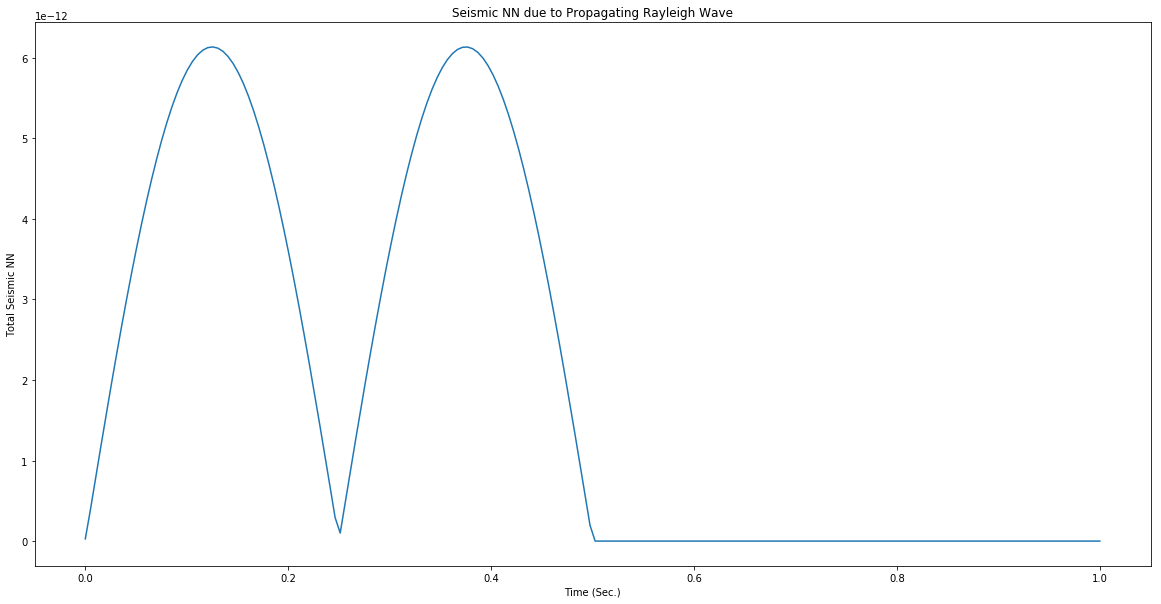

In [6]:
T_list = np.zeros(len(t2_list))

for i, tn in enumerate(t2_list):
    T_list[i] = seisnn3d_total(tn, 2, np.pi/4, 0, 250, 250, 1)
    
fig = plt.figure(figsize =(20,10))
ax = fig.add_subplot(111, xlabel = 'Time (Sec.)', ylabel = 'Total Seismic NN', title = 'Seismic NN due to Propagating Rayleigh Wave')
ax.plot(t2_list, T_list)

In [38]:
#Newtonian noise from a Rayleigh wave in three dimensions

#Defining constants
G = 6.67e-11 #Newton's constant of gravitation

x2_list = np.linspace(0, 500, 201) #x-values to be evaluated
y2_list = np.linspace(0, 500, 201) #y-values to be evaluated
z2_list = np.array([0]) #z-values to be evaluated
t2_list = np.linspace(3, 5, 50) #time interval to be evaluated over
V = (500 * 500 * 100)/(len(x2_list) * len(y2_list) * len(z2_list))

#Calculating the Seismic Newtonian Noise contribution of a single point using equation (4.13) from Beker's thesis paper on pg. 92
def seisnn3d(x, y, z, t, f, theta, phi, x0, y0, z0):
    r = [x - x0, y - y0, z - z0] #vector from point to test mass
    r_mag = np.linalg.norm(r) #magnitude of r vector
    r_hat = r / r_mag #unit vector in r direction
    xi = xi_vect(x, y, z, t, f, theta, phi)
    return G * rho0 * V * (1.0 / r_mag**3) * (xi - 3 * np.dot(r_hat, xi) * r_hat)

grid = itertools.product(x2_list, y2_list, z2_list) #Creating Cartesian product of the lists for each direction
gridlist = list(grid) #Creating list of the Cartesian products
points = len(x2_list) * len(y2_list) * len(z2_list) #Calculatin the number of points in the array
nnlist = np.zeros((1,1,points,3)) #Defining list to place the Newtonian Noise calculation at each point into

#Defining a spiral array to use for the Newtonian Noise calculation
pointlist = np.array([[[0,0,0], [np.pi * np.sqrt(3) / 12, np.pi / 12, 0], [np.pi * np.sqrt(2) / 8, np.pi * np.sqrt(2) / 8, 0], [-np.pi / 3, np.pi * np.sqrt(3) / 3, 0], [-np.pi, 0, 0], [- 5 * np.pi * np.sqrt(2) / 8, -5 * np.pi * np.sqrt(2) / 8, 0], [0, -3 * np.pi / 2, 0], [11 * np.pi * np.sqrt(3)/12, -11*np.pi/12,0], [2*np.pi, 0, 0], [7 * np.pi/6, 7*np.pi*np.sqrt(3)/6,0], [17*np.pi*np.sqrt(3)/12, 17*np.pi/2, 0]]])

#Defining function to calculate total Seismic Newtonian Noise at a single point in time
def seisnn3d_total(t, f, theta, phi, x0, y0, z0):
    for i, p in enumerate(gridlist):
        x = gridlist[i][0] #Referencing the x-coordinate of each Cartesian product in gridlist
        y = gridlist[i][1] #Referencing the y-coordinate of each Cartesian product in gridlist
        z = gridlist[i][2] #Referencing the z-coordinate of each Cartesian product in gridlist
        nnlist[0,0,i] = seisnn3d(x, y, z, t, f, theta, phi, x0, y0, z0)
    nntotal = np.sum(nnlist, 2)
    nntotal_mag = np.linalg.norm(nntotal)
    return nntotal_mag

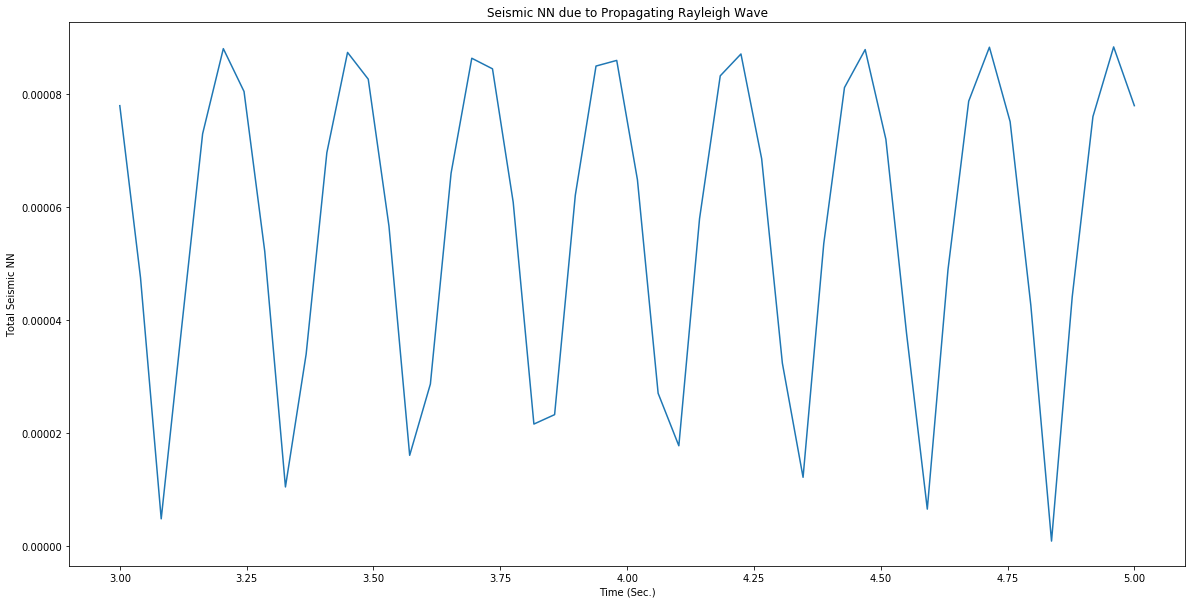

In [39]:
T_list = np.zeros(len(t2_list))

for i, tn in enumerate(t2_list):
    T_list[i] = seisnn3d_total(tn, 2, np.pi/4, 0, 250,250,1)

fig = plt.figure(figsize =(20,10))
ax = fig.add_subplot(111, xlabel = 'Time (Sec.)', ylabel = 'Total Seismic NN', title = 'Seismic NN due to Propagating Rayleigh Wave')
ax.plot(t2_list, T_list)

In [37]:
np.sum(T_list) / len(T_list)

1.3362377501999609e-05

In [40]:
np.sum(T_list) / len(T_list)

5.666730387901854e-05